# Marker Detection

The goal of this notebook is to detect road markers using Computer Vision. The images are taken from the viewpoint of a camera‐carrying model car driving on a track marked with yellow tape. 

I will be using the IoU score to calculate the accuracy of the Computer Vision algorithm. IoU (Intersection Over Union) is the algorithm that is used by most of the object detection algorithms such as Yolo. 

In [1]:
from __future__ import division
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import ast
%matplotlib inline

In [2]:
INPUT_DIR = './data'
YELLOW_SPECTRUM = np.array([[0, 150, 150], [100, 255, 255]])
#YELLOW_SPECTRUM2 = np.array([[140, 212, 203], [0, 255, 222]])

green = (0, 255, 0)
red = (255, 0, 0)
font = cv2.FONT_HERSHEY_SIMPLEX

In [3]:
#Add a gray dark overlay on the image
def overlay_mask(mask, image):
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    image_overlayed = cv2.addWeighted(mask, 0.5, image, 0.5, 1)
    return image_overlayed

In [4]:
def annotate(mask, image):
    annotation_dict = []
    image_with_annotations = image.copy()
    
    #get the areas that are detected by the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    #loop through each detected area and draw a rectangle around it
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_annotations, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        rectangle = {"geometry": [{"x" : x, "y": y}, {"x" : x+w, "y": y+h}]}
        annotation_dict.append(rectangle)
    return image_with_annotations, annotation_dict

In [5]:
def detect_markers(image):
    #convert image to hsv
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #create the yellow mask to detect yellow markers
    mask = cv2.inRange(image_hsv, YELLOW_SPECTRUM[0], YELLOW_SPECTRUM[1]) 
    
    #mask2 = cv2.inRange(image_hsv, YELLOW_SPECTRUM2[0], YELLOW_SPECTRUM2[1])
    #mask = cv2.bitwise_or(mask1, mask2)   
    
    #create kernels to hold the matched masks
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    
    #Opening is just another name of erosion followed by dilation. It is useful in removing noise
    mask_opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.
    mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    #overlay the image with the mask with detected yellow areas to pop the detected areas in the image
    overlay = overlay_mask(mask_opening, image)
    
    #create rectangle annotations around the detected areas
    image_with_annotations, annotation_dict = annotate(mask_opening, overlay)

    return [image, mask_opening, image_with_annotations, annotation_dict]

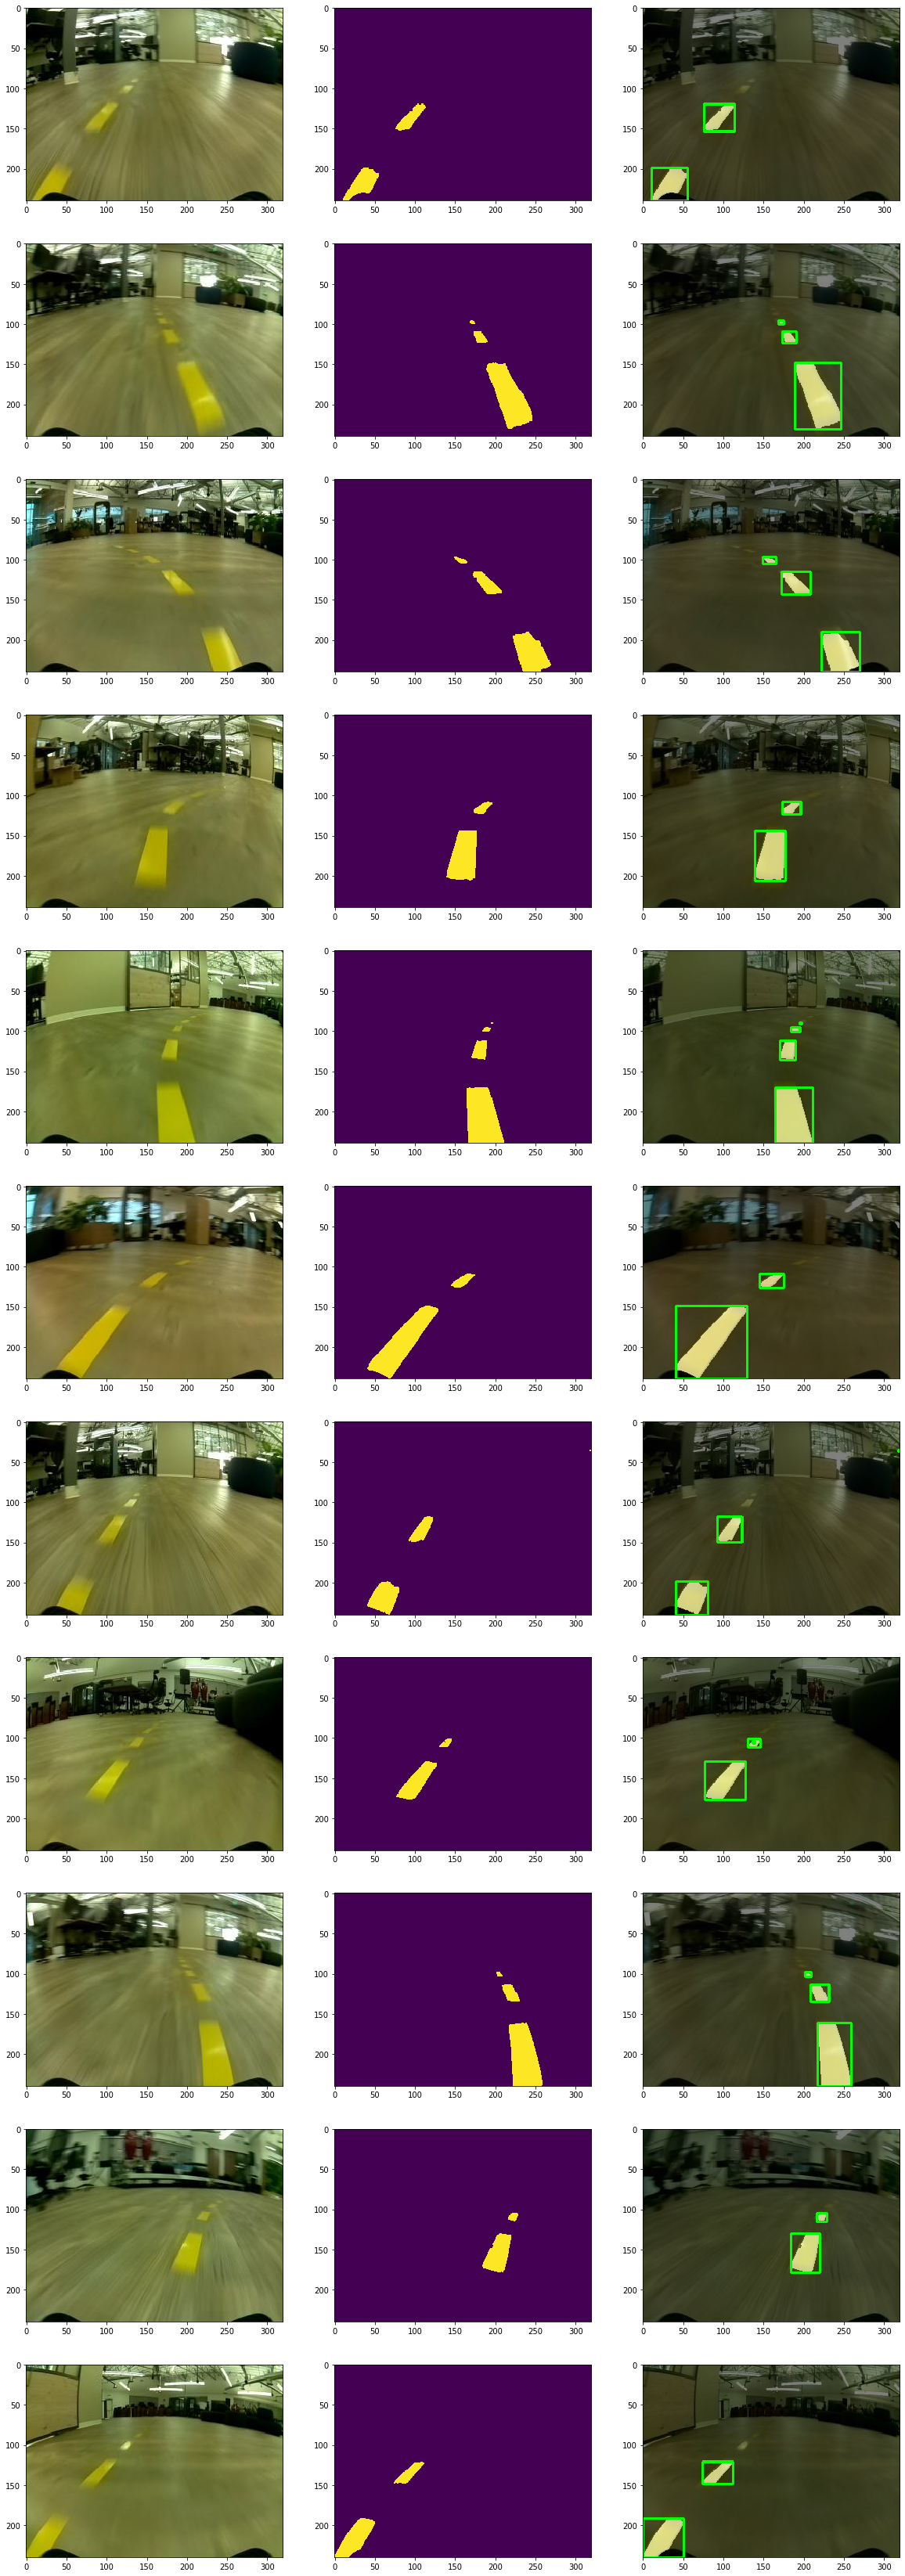

In [6]:
#create a dataframe to save the predicted annotations for each file in the same format that our human labeled annotations
predicted_annotations = pd.DataFrame(columns=['annotations', 'filename'])

#create a figure to print our images in 3X11 canvas
fig, axs = plt.subplots(nrows=11, ncols=3, figsize=(20, 60))

#loop through files and print their results for each row
for i, filename in enumerate(os.listdir(INPUT_DIR)):
    image = cv2.imread(os.path.join(INPUT_DIR, filename))
    result = detect_markers(image)
    
    #original image
    axs[i,0].imshow(result[0], interpolation='nearest')
    
    #mask result
    axs[i,1].imshow(result[1], interpolation='nearest')
    
    #annotated image
    axs[i,2].imshow(result[2], interpolation='nearest')  

    #create the prediction annotations dictionary in same format with our human labeled annotations
    predicted_annotations_dict = {"Yellow marker": result[3]}

    #add the annotation dictionary and the filename to the dataframe
    predicted_annotations.loc[i] = [str(predicted_annotations_dict)] + [filename] 
    
#fig.savefig('result.png', dpi=300)
plt.show();

### Accuracy Analysis

Note that the bounding boxes oriented along the image is the best metric, because it gives a better approximation of the object detection. However, I chose the annotation style to imitate the common object detection algorithms out there (such as Yolo). In Deep Learning based Object Detection algorithms, the annotation boxes are not oriented along the objects, because of the way the algorithm/convolution works. It splits the image to rectangles (usually 19 boxes) and scans the image until it finds the best bounding box that has the best IoU score for the corresponding class that it detects. The algorithm doesn't rotate or reorient the anchor boxes that it is looking for in the image. It would be a nice improvement for cases where it needs the orientation of the object along with the object location, but probably it is a very expensive one too. Usually object detection problems are real time detection problems, so speed is important. I also think that it is easier to label data with not oriented boxes. 

For more info on oriented and not oriented bounding boxes using OpenCv:
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

For more info on IoU: 
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

The human labeled annotations are created by LabelBox. I created a demo project and labeled the images manually and exported the results.

In [7]:
#show a given image
def show(image):
    plt.figure(figsize=(6,6))
    plt.imshow(image, interpolation='nearest')

In [8]:
"""
I implemented my own IoU algorithm as I didn't take advantage of the ML libraries' (Keras, Tensorflow) IoU algorithm. 
The below code can probably be shortened.
"""
def iou(b1, b2):
    #get the top left and bottom right coordinates of the boxes
    b1x1 = min(b1[0], b1[2])
    b1y1 = min(b1[1], b1[3])
    b1x2 = max(b1[0], b1[2])
    b1y2 = max(b1[1], b1[3])
    
    b2x1 = min(b2[0], b2[2])
    b2y1 = min(b2[1], b2[3])
    b2x2 = max(b2[0], b2[2])
    b2y2 = max(b2[1], b2[3])
    
    #get top left and bottom right coordinate for the intersection
    cx1 = max(b1x1, b2x1)
    cy1 = max(b1y1, b2y1)
    cx2 = min(b1x2, b2x2)
    cy2 = min(b1y2, b2y2)

    #check if the boxes intersects
    b1_intersects_b2 = cx2 > cx1 and cy2 > cy1
    
    #calculate the union and IoU score if boxes intersect
    if b1_intersects_b2:
        area_c = (cx2 - cx1) * (cy2 - cy1)
        area_b1 = (b1x2 - b1x1) * (b1y2 - b1y1)
        area_b2 = (b2x2 - b2x1) * (b2y2 - b2y1)
        union = area_b1 + area_b2 - area_c
        return area_c / union
    return 0

In [9]:
#Annotations that the computer vision algorithm could predict
predicted_annotations.head(5)

annotations  \
0  {'Yellow marker': [{'geometry': [{'x': 11, 'y'...   
1  {'Yellow marker': [{'geometry': [{'x': 189, 'y...   
2  {'Yellow marker': [{'geometry': [{'x': 222, 'y...   
3  {'Yellow marker': [{'geometry': [{'x': 139, 'y...   
4  {'Yellow marker': [{'geometry': [{'x': 164, 'y...   

                    filename  
0   786_cam-image_array_.jpg  
1   742_cam-image_array_.jpg  
2  1266_cam-image_array_.jpg  
3   711_cam-image_array_.jpg  
4   863_cam-image_array_.jpg

In [10]:
#Annotations labeled by humans (by me :)) 
labeled_annotations = pd.read_csv('export-2019-06-29T07_04_27.318Z.csv', usecols = ['Label', 'External ID'])

In [11]:
pd.set_option('display.max_colwidth', -1)
labeled_annotations.head(5)

Label  \
0  {"Yellow marker":[{"geometry":[{"x":177,"y":217},{"x":134,"y":139}]},{"geometry":[{"x":198,"y":108},{"x":169,"y":126}]},{"geometry":[{"x":224,"y":97},{"x":205,"y":105}]}]}   
1  {"Yellow marker":[{"geometry":[{"x":63,"y":194},{"x":7,"y":240}]},{"geometry":[{"x":118,"y":119},{"x":73,"y":155}]},{"geometry":[{"x":134,"y":97},{"x":116,"y":108}]}]}       
2  {"Yellow marker":[{"geometry":[{"x":221,"y":128},{"x":180,"y":182}]},{"geometry":[{"x":232,"y":103},{"x":212,"y":116}]}]}                                                     
3  {"Yellow marker":[{"geometry":[{"x":88,"y":193},{"x":38,"y":239}]},{"geometry":[{"x":128,"y":116},{"x":88,"y":152}]},{"geometry":[{"x":140,"y":96},{"x":121,"y":106}]}]}      
4  {"Yellow marker":[{"geometry":[{"x":214,"y":158},{"x":262,"y":240}]},{"geometry":[{"x":205,"y":113},{"x":232,"y":136}]},{"geometry":[{"x":197,"y":96},{"x":211,"y":104}]}]}   

                 External ID  
0  711_cam-image_array_.jpg   
1  786_cam-image_array_.jpg   
2  1100_cam-image_array_.jpg  
3  1463_cam-image_array_.jpg  
4  735_cam-image_array_.jpg

In [12]:
def iou_scores(labeled_boxes, predicted_boxes):
    #array that stores the best score for the labeled box
    results = []   
    
    #loop through labeled boxes and calcuate the IoU score
    for labeled_box in labeled_boxes:
        scores = []
        for predicted_box in predicted_boxes:
            iou_score = iou(predicted_box, labeled_box)
            scores.append(iou_score)
        results.append([max(scores), labeled_box])
    return results

In [13]:
#draw the annotated box on the image and return boxes' coordinates in a [x1, y1, x2, y2] format
def draw_annotations(annotations, image, color):
    image_annotated = image.copy()
    boxes = []
    for annotation in annotations.get("Yellow marker"):
        x1, y1 = annotation.get("geometry")[0].values()
        x2, y2 = annotation.get("geometry")[1].values()
        cv2.rectangle(image_annotated, (x1, y1), (x2, y2), color, 1)
        boxes.append([x1, y1, x2, y2])
    return image_annotated, boxes

In [14]:
#write the best score by the given labeled box
def draw_scores(scores, image):
    image_scores = image.copy()
    for score, box in scores: 
        cv2.putText(image_scores, str(round(score, 2)) , (box[0] +5, box[1] + 10), font, 0.3, (255,255,255), 1, cv2.LINE_AA)
    return image_scores

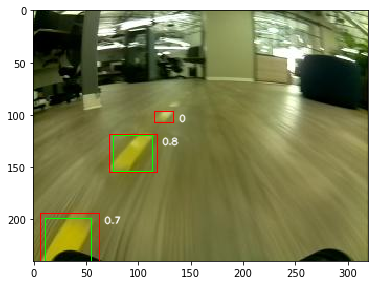

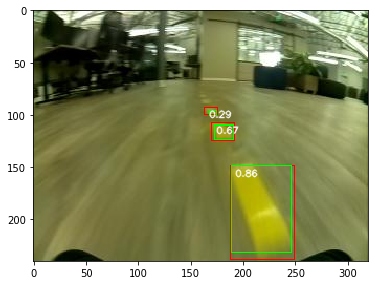

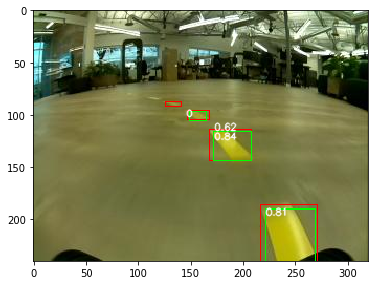

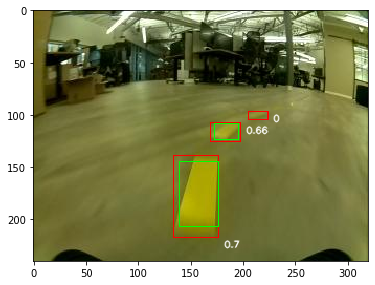

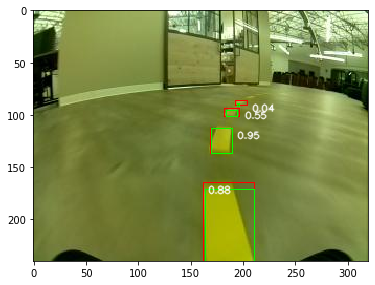

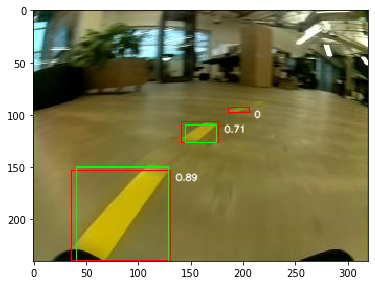

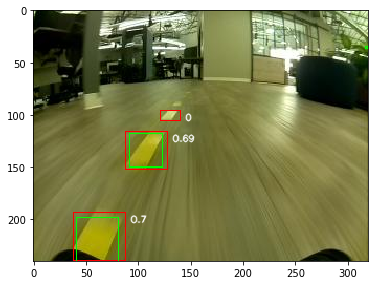

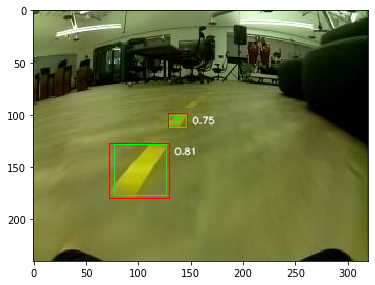

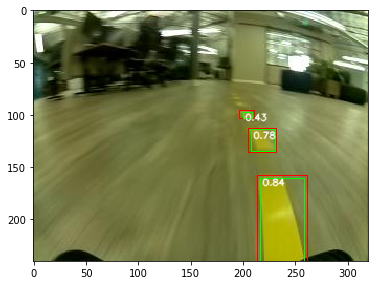

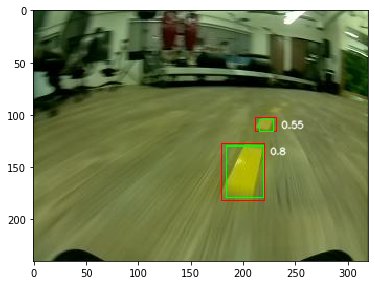

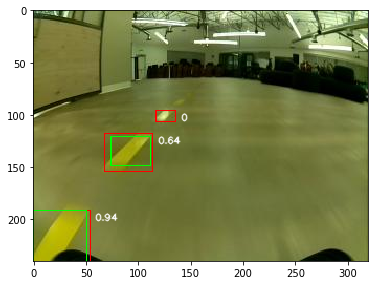

In [15]:
for filename in os.listdir(INPUT_DIR):
    #read image
    image = cv2.imread(os.path.join(INPUT_DIR, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    #get human annotations
    labeled_annotation = ast.literal_eval(labeled_annotations[labeled_annotations["External ID"] == filename]['Label'].values[0])
    image, labeled_boxes = draw_annotations(labeled_annotation, image, red)
    
    #get computer vision annotations
    predicted_annotation = ast.literal_eval(predicted_annotations[predicted_annotations['filename'] == filename]['annotations'].values[0])
    image, predicted_boxes = draw_annotations(predicted_annotation, image, green)
    
    #get the best IoU score for the labeled box
    scores = iou_scores(labeled_boxes, predicted_boxes)
    
    img = draw_scores(scores, image)
    show(img)

Results: 
    - An Intersection over Union score > 0.5 is normally considered a “good” prediction. The Computer Vision Algorithm is doing pretty well.
    - The performance is compared with human performance, which is the best performance that can be achieved in terms of this problem
    - The colors are not very sharp and the ground has some blending colors with the yellow and some markers have some glare on them. Therefore, some of the yellow markers are missed. They could be included by adding more masks, but some invalid areas would be picked along with the missed yellow markers as well. I decided to stop here and have some missing markers to have examples for IoU scores for non-intersecting boxes.